In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

In [2]:
df_bogor = pd.concat([
  gpd.read_file("../dataset/shp/kota/ADMINISTRASIDESA_AR_25K.shp"), 
  gpd.read_file("../dataset/shp/kab/ADMINISTRASIDESA_AR_25K.shp")
])

df_bogor = df_bogor.drop(columns=["KDPPUM","REMARK","KDPBPS","FCODE","LUASWH","UUPP","SRS_ID","METADATA","KDEBPS","KDEPUM","KDCBPS","KDCPUM","KDBBPS","KDBPUM","WADMKD","WIADKD","WIADKC","WIADKK","WIADPR","TIPADM"])
df_bogor.head()

,NAMOBJ,LCODE,WADMKC,WADMKK,WADMPR,SHAPE_Leng,SHAPE_Area,geometry
0,Atangsenjaya,BA0020,Kemang,Bogor,Jawa Barat,0.050011,0.000142,"MULTIPOLYGON Z (((106.76135 -6.54978 0.00000, ..."
1,Babakan,BA0020,Bogor Tengah,Kota Bogor,Jawa Barat,0.039368,0.000084,"POLYGON Z ((106.81147 -6.58549 0.00000, 106.81..."
2,Babakan,BA0020,Dramaga,Bogor,Jawa Barat,0.090427,0.000272,"MULTIPOLYGON Z (((106.73532 -6.56320 0.00000, ..."
3,Babakanpasar,BA0020,Bogor Tengah,Kota Bogor,Jawa Barat,0.022805,0.000026,"POLYGON Z ((106.80666 -6.60793 0.00000, 106.80..."
4,Balumbangjaya,BA0020,Bogor Barat,Kota Bogor,Jawa Barat,0.056478,0.000109,"POLYGON Z ((106.74774 -6.56118 0.00000, 106.74..."


In [3]:
df_bogor.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
# https://epsg.io/4326
# WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS

df_overpass_raw = pd.read_parquet("../dataset/etl/L1.overpass.parquet")
df_overpass = gpd.GeoDataFrame(df_overpass_raw, geometry=gpd.points_from_xy(df_overpass_raw.lon, df_overpass_raw.lat), crs="EPSG:4326")
df_overpass = df_overpass.drop(columns=["lat","lon"])

df_overpass.head()

,id,rel,amenity,type,category,geometry
0,1354137371,14762112,hospital,node,healthcare,POINT (106.81427 -6.39455)
1,1354148415,14762112,hospital,node,healthcare,POINT (106.79589 -6.39463)
2,1752239081,14762112,hospital,node,healthcare,POINT (106.62749 -6.57479)
3,1752506570,14762112,hospital,node,healthcare,POINT (106.63713 -6.57623)
4,2052421657,14762112,hospital,node,healthcare,POINT (106.73291 -6.42026)


In [25]:
df_overpass.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Plots

<Axes: >

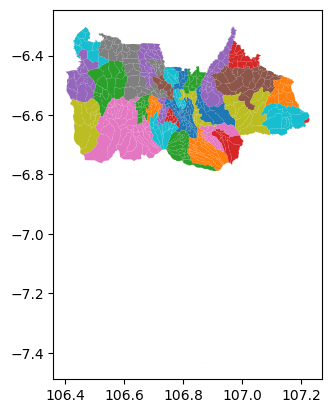

In [6]:
df_bogor.plot(column="WADMKC")

## Intersections

In [17]:
# https://epsg.io/23839
# DGN95 / Indonesia TM-3 zone 51.1

df_intersect = gpd.sjoin_nearest(df_bogor.to_crs("EPSG:23839"), df_overpass.to_crs("EPSG:23839"), distance_col="distance").drop(columns=["index_right"])
df_places = pd.DataFrame(df_intersect.drop(columns=["geometry", "SHAPE_Leng", "SHAPE_Area"]))

df_places.head()

,NAMOBJ,LCODE,WADMKC,WADMKK,WADMPR,id,rel,amenity,type,category,distance
0,Atangsenjaya,BA0020,Kemang,Bogor,Jawa Barat,8961582717,14745927,school,node,education,143.420189
38,Curug,BA0020,Bogor Barat,Kota Bogor,Jawa Barat,8961582717,14745927,school,node,education,0.000000
195,Curug,BA0020,Bogor Barat,Kota Bogor,Jawa Barat,8961582717,14745927,school,node,education,141.853178
1,Babakan,BA0020,Bogor Tengah,Kota Bogor,Jawa Barat,183499017,14745927,parking,way,transportation,0.000000
1,Babakan,BA0020,Bogor Tengah,Kota Bogor,Jawa Barat,5507176222,14745927,cafe,node,sustenance,0.000000


## Join with House Prices

In [43]:
place_norm = {
    # from houses to SHP
    # "Pajajaran": "Babakan",
    # "Taman Kencana": "Babakan",
    "Babakan Madang": "Babakanmadang",
    # "Bukit Sentul": "Babakanmadang",
    "Babakan Pasar": "Babakanpasar",
    "Balumbang Jaya": "Balumbangjaya",
    "Bantar Jati": "Bantarjati",
    # "Indraprasta": "Bantarjati",
    # "Ardio": "Bogor Tengah",
    "Bojong Gede": "Bojonggede",
    "Bojong Kulur": "Bojongkulur",
    # "Cilendek": "Cilendek Barat",
    "Curug Mekar": "Curugmekar",
    "Gunung Batu": "Gunungbatu",
    "Gunung Putri": "Gunungputri",
    # "Kota Wisata": "Gunungputri",
    # "Legenda Wisata": "Gunungputri",
    # "Kranggan": "Gunungputri",
    "Gunung Sindur": "Gunungsindur",
    # "Harjamukti": "INI GA ADA DI SHP",
    "Karang Tengah": "Karangtengah",
    "Kebon Kelapa": "Kebonkalapa",
    "Kedungbadak": "Kedungbadak",
    "Kedung Halang": "Kedunghalang",
    "Leuwinanggung": "Lewinanggung",
    # "Jl Dr Semeru": "Menteng",
    "Muara Sari": "Muarasari",
    # "Bogor Nirwana Residence": "Mulyaharja",
    "Parung Panjang": "Parungpanjang",
    "Pasir Jaya": "Pasirjaya",
    "Pasir Kuda": "Pasirkuda",
    "Pasir Muncang": "Pasirmuncang",
    "Ranca Bungur": "Rancabungur",
    "Rangga Mekar": "Ranggamekar",
    "Sentul City": "Sentul",
    "Sindang Barang": "Sindangbarang",
    "Sindang Sari": "Sindangsari",
    "Situ Gede": "Situgede",
    "Tajur Halang": "Tajurhalang",
    # "Ahmadyani": "Tanahsareal",
    # "Jl A Yani": "Tanahsareal",
    "Tanah Sareal": "Tanahsareal",
    "Tegal Gundi": "Tegalgundil",
    "Tegal Gundil": "Tegalgundil",
    "Duta Pakuan": "Tegallega",

    # dedupe in SHP
    "Bantar Gebang" :"Bantargebang",
}

In [44]:
df_houses = pd.read_parquet("../dataset/etl/L2.regression_inliers.parquet")
df_houses["place"] = df_houses["district"].replace(place_norm)
# df_houses["place"] = df_houses["district"]
df_houses["price"] = np.log(df_houses["price"])
avg_house_prices = df_houses.groupby("place")["price"].mean()
avg_house_prices.head()

place
Ahmadyani        6.878231
Ardio            6.429960
Babakan          7.452802
Babakanmadang    7.441180
Babakanpasar     7.675284
Name: price, dtype: float64

In [51]:
df_amenities = pd.concat([
    # df_places.pivot_table(index="WADMKC", columns="category", values="id", aggfunc="count", fill_value=0).reset_index().rename(columns={"WADMKC": "place"}),
    df_places.pivot_table(index="NAMOBJ", columns="category", values="id", aggfunc="count", fill_value=0).reset_index().rename(columns={"NAMOBJ": "place"}),
])

df_amenities["place"] = df_amenities["place"].replace(place_norm)
df_amenities.head()

category,place,education,entertainment,facilities,financial,healthcare,public_service,sustenance,transportation
0,Ambar Jaya,1,0,0,0,0,0,0,0
1,Antajaya,0,0,0,0,0,0,1,0
2,Argapura,0,0,0,0,0,0,1,0
3,Atangsenjaya,1,0,0,0,1,0,0,0
4,Babakan,21,0,1,18,4,1,21,17


In [52]:
df_summary = df_amenities.join(avg_house_prices, on="place", how="right").reset_index(drop=True)
df_summary.sort_values("price", ascending=False).head().style.background_gradient(cmap="Blues")

,place,education,entertainment,facilities,financial,healthcare,public_service,sustenance,transportation,price
108,Pasirmuncang,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.411833
60,Gadog,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,8.145594
95,Pabaton,16.000000,0.000000,0.000000,31.000000,5.000000,7.000000,11.000000,25.000000,8.119480
92,Megamendung,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.014258
135,Tegallega,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.901234


<Axes: >

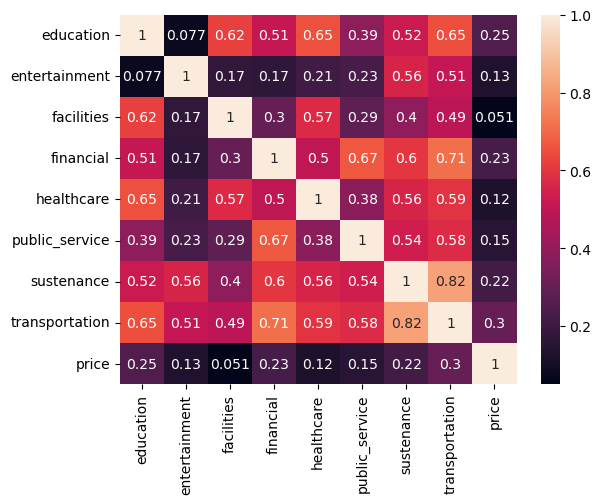

In [53]:
sns.heatmap(df_summary.corr(numeric_only=True), annot=True)